# Import libraries

In [1]:
# Data wrangling
import pandas as pd
import numpy as np

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy.stats import norm, boxcox_normmax
from scipy.special import boxcox1p

# Modelling
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Miscellaneous
from collections import Counter

# Import and read data

In [2]:
train = pd.read_csv("C:/Users/Jason Chong/Documents/Kaggle/house-prices/train.csv")
test = pd.read_csv("C:/Users/Jason Chong/Documents/Kaggle/house-prices/test.csv")
ss = pd.read_csv("C:/Users/Jason Chong/Documents/Kaggle/house-prices/sample_submission.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
ss.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [6]:
# Combine training and test set

combine = pd.concat([train, test])

In [7]:
# All dataframe shape

print("Training set shape: ", train.shape)
print("Test set shape: ", test.shape)
print("Combined shape: ", combine.shape)
print("Sample submission shape: ", ss.shape)

Training set shape:  (1460, 81)
Test set shape:  (1459, 80)
Combined shape:  (2919, 81)
Sample submission shape:  (1459, 2)


# Descriptive statistics

In [8]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [9]:
test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,1459.0,2190.000000,421.321334,1461.0,1825.50,2190.0,2554.50,2919.0
MSSubClass,1459.0,57.378341,42.746880,20.0,20.00,50.0,70.00,190.0
LotFrontage,1232.0,68.580357,22.376841,21.0,58.00,67.0,80.00,200.0
LotArea,1459.0,9819.161069,4955.517327,1470.0,7391.00,9399.0,11517.50,56600.0
OverallQual,1459.0,6.078821,1.436812,1.0,5.00,6.0,7.00,10.0
OverallCond,1459.0,5.553804,1.113740,1.0,5.00,5.0,6.00,9.0
YearBuilt,1459.0,1971.357779,30.390071,1879.0,1953.00,1973.0,2001.00,2010.0
YearRemodAdd,1459.0,1983.662783,21.130467,1950.0,1963.00,1992.0,2004.00,2010.0
MasVnrArea,1444.0,100.709141,177.625900,0.0,0.00,0.0,164.00,1290.0
BsmtFinSF1,1458.0,439.203704,455.268042,0.0,0.00,350.5,753.50,4010.0


# Data types

In [10]:
combine.dtypes.value_counts()

object     43
int64      26
float64    12
dtype: int64

# Exploratory data analysis (EDA)

Text(0.5, 1.0, 'Sale Price Distribution')

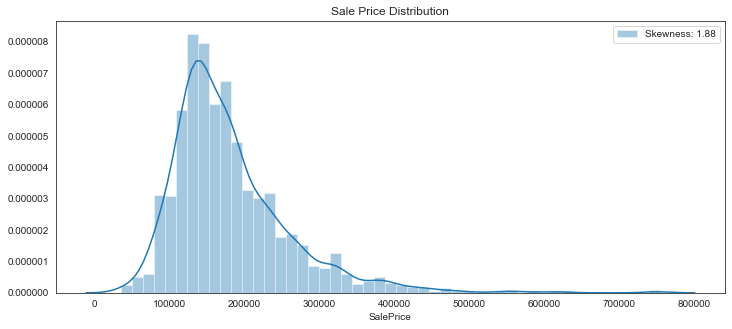

In [11]:
# Sale price distribution

plt.figure(figsize = (12, 5))
sns.set_style('white')
sns.distplot(train['SalePrice'], label = 'Skewness: %.2f'%train['SalePrice'].skew())
plt.legend(loc = 'best')
plt.title('Sale Price Distribution')

In [12]:
# Skewness and kurtosis

print("Skewness: %f"%train['SalePrice'].skew())
print("Kurtosis: %f"%train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


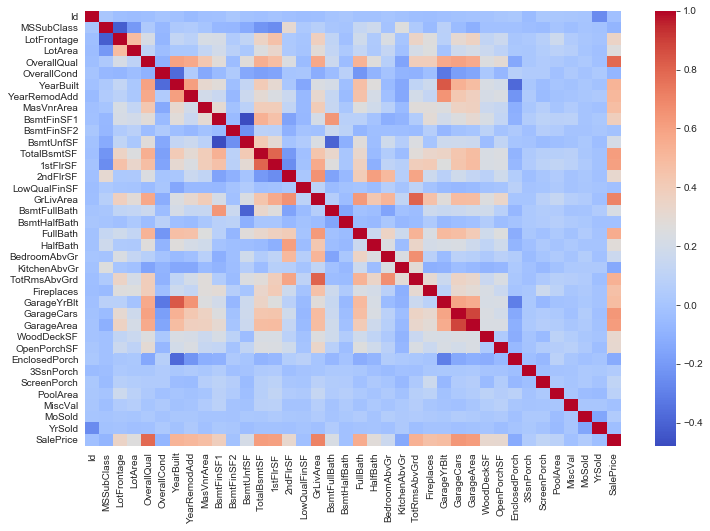

In [13]:
# Correlation between numerical variables

corr = combine.corr()
plt.figure(figsize = (12, 8))
sns.heatmap(corr, cmap = 'coolwarm')

# Comment: There are signs of multicollinearity between some features, can remove them to prevent overfitting 

There is a strong correlation between:

- TotalBsmtSF and 1stFlrSF
- GarageCars and GarageArea
- GarageYrBlt and YearBuilt
- TotRmsAbvGrd and GrLivArea

In [14]:
# Features most correlated with sale price

corr['SalePrice'].sort_values(ascending = False).head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

We observe that many of the top 10 most correlated features also have correlation with each other. If there is a correlated pair, I will choose to examine the feature that has a higher correlation with sale price 

Text(0.5, 1, 'Sale Price Against Overall Quality')

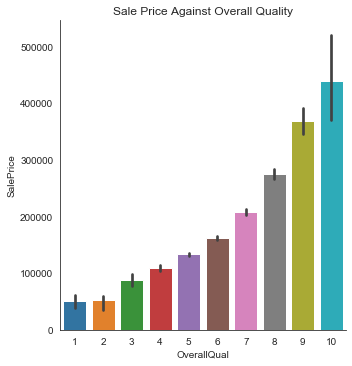

In [15]:
# Sale price against overall quality 

sns.set_style('white')
sns.factorplot(x = 'OverallQual', y = 'SalePrice', data = train, kind = 'bar')
plt.title('Sale Price Against Overall Quality')

Sale price increases with overall quality but we don't know how overall quality is determined.

Text(0.5, 1.0, 'Sale Price Against GrLivArea')

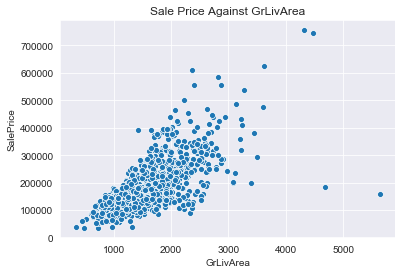

In [16]:
# Sale price against GrLivArea

sns.set_style('darkgrid')
sns.scatterplot(x = 'GrLivArea', y = 'SalePrice', data = train)
plt.title('Sale Price Against GrLivArea')

We observe two outliers in the scatter plot with large GrLivArea but low sale price. We need to deal with them later on. 

Text(0.5, 1, 'Sale Price Against Garage Cars')

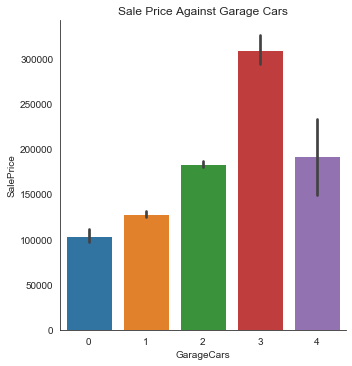

In [17]:
# Sale price against garage cars

sns.set_style('white')
sns.factorplot(x = 'GarageCars', y = 'SalePrice', data = train, kind = 'bar')
plt.title('Sale Price Against Garage Cars')

Houses with 3 garage cars have the highest sale price. 

Text(0.5, 1.0, 'Sale Price Against TotalBsmtSF')

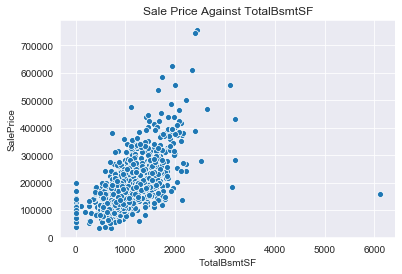

In [18]:
# Sale price against TotalBsmtSF

sns.set_style('darkgrid')
sns.scatterplot(x = 'TotalBsmtSF', y = 'SalePrice', data = train)
plt.title('Sale Price Against TotalBsmtSF')

Another outlier!

Text(0.5, 1, 'Sale Price Against Full Bath')

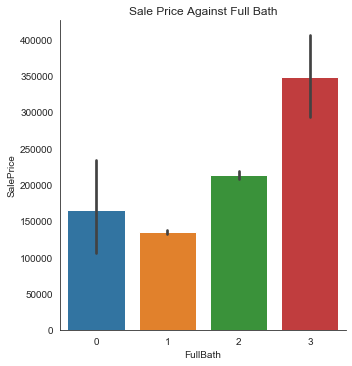

In [19]:
# Sale price against FullBath

sns.set_style('white')
sns.factorplot(x = 'FullBath', y = 'SalePrice', data = train, kind = 'bar')
plt.title('Sale Price Against Full Bath')

Text(0.5, 1.0, 'Sale Price Against Year Built')

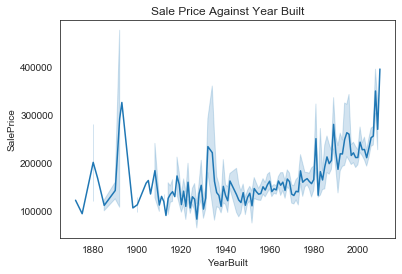

In [20]:
# Sale price against year built

sns.set_style('white')
sns.lineplot(x = 'YearBuilt', y = 'SalePrice', data = train)
plt.title('Sale Price Against Year Built')

House prices are trending upwards in general.

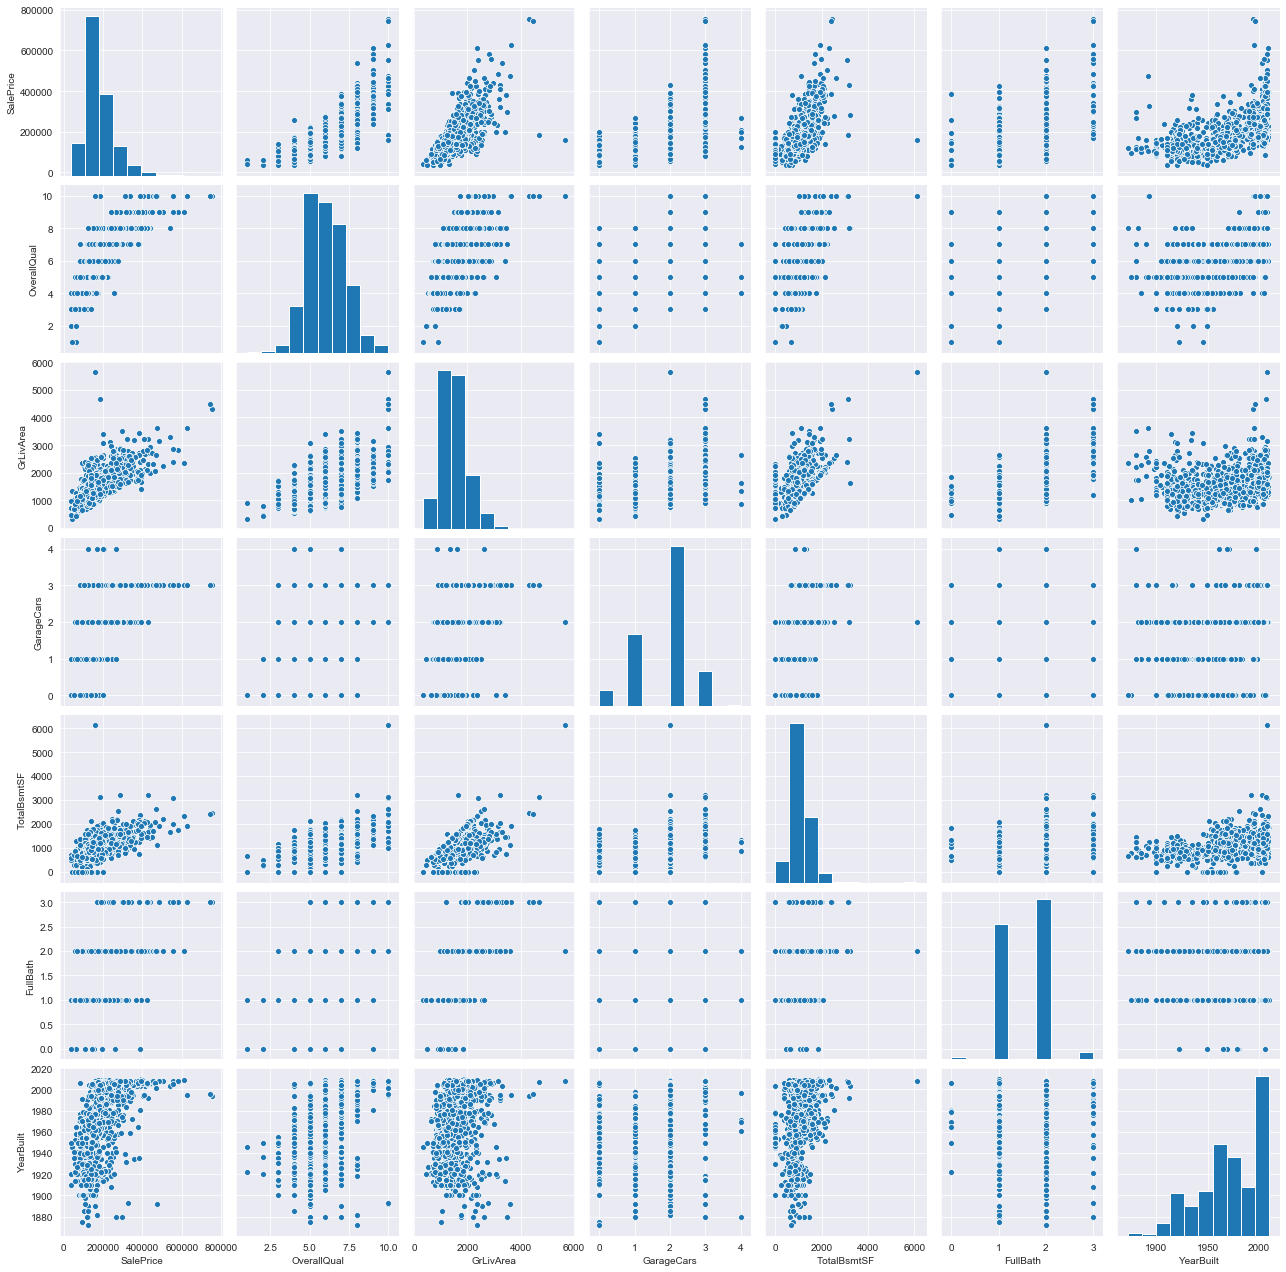

In [21]:
# Create a mega scatter plot

sns.set_style('darkgrid')
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols])

# Missing data

In [22]:
# Missing data in combined dataframe
missing = combine.isnull().sum()
missing = missing[missing > 0]

# Percentage missing
percent_missing = missing / len(combine)

# Concat missing and percentage missing
missing_df = pd.concat([missing, percent_missing], axis = 1, keys = ['Total', 'Percent'])

# Drop sale price because test set does not have sale price
missing_df = missing_df.drop('SalePrice')

# Create dataframe for missing data 
missing_df.sort_values(by = 'Total', ascending = False, inplace = True)
missing_df

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageFinish,159,0.054471
GarageQual,159,0.054471
GarageCond,159,0.054471
GarageYrBlt,159,0.054471


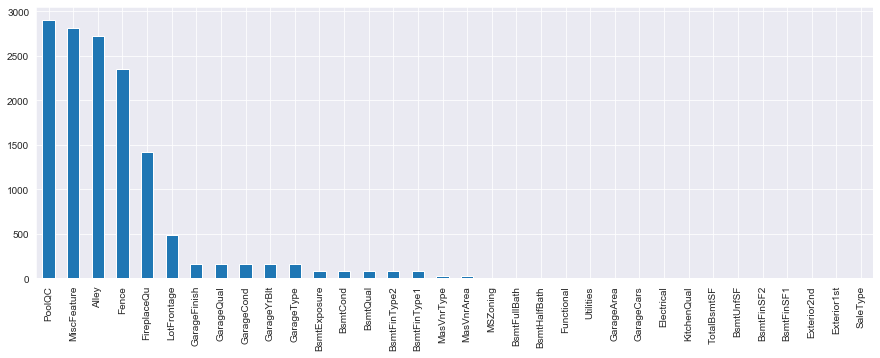

In [23]:
# Columns with missing data

plt.figure(figsize = (15, 5))
missing_df['Total'].plot(kind = 'bar')

In [24]:
print("Number of features with missing data in combined dataframe: ", len(missing_df))

Number of features with missing data in combined dataframe:  34


In [25]:
# Features to drop

features_to_drop = missing_df[missing_df['Total'] > 4].index
print(f"We are dropping {len(features_to_drop)} features from the dataset. ")
features_to_drop

We are dropping 18 features from the dataset. 


Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'GarageType',
       'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1',
       'MasVnrType', 'MasVnrArea'],
      dtype='object')

In [26]:
# Features to fill

features_to_fill = missing_df[missing_df['Total'] <= 4].index
print(f"We are dropping {len(features_to_fill)} features from the dataset. ")
features_to_fill

We are dropping 16 features from the dataset. 


Index(['MSZoning', 'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'Utilities',
       'GarageArea', 'GarageCars', 'Electrical', 'KitchenQual', 'TotalBsmtSF',
       'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1', 'Exterior2nd', 'Exterior1st',
       'SaleType'],
      dtype='object')

In [27]:
# Drop features from combined dataframe

combine = combine.drop(columns = features_to_drop, axis = 1)

Before we fill the missing data, we should check the data types of those features.

In [28]:
# Check data types

combine[features_to_fill].dtypes

MSZoning         object
BsmtFullBath    float64
BsmtHalfBath    float64
Functional       object
Utilities        object
GarageArea      float64
GarageCars      float64
Electrical       object
KitchenQual      object
TotalBsmtSF     float64
BsmtUnfSF       float64
BsmtFinSF2      float64
BsmtFinSF1      float64
Exterior2nd      object
Exterior1st      object
SaleType         object
dtype: object

In [29]:
# Separate numerical and categorical features

numerical_features = [feature for feature in features_to_fill if 'Area' in feature or 'SF' in feature]
categorical_features = [feature for feature in features_to_fill if feature not in numerical_features]

In [30]:
# Fill numerical features with mean
for feature in numerical_features:
    combine[feature] = combine[feature].fillna(combine[feature].mean())

# Fill categorical features with mode
for feature in categorical_features:
    combine[feature] = combine[feature].fillna(combine[feature].mode()[0])

In [31]:
# Make sure there is no more missing data

combine.drop('SalePrice', axis = 1).isnull().sum().max()

0

In [32]:
# Split training and test set from combined dataframe

train = combine[:len(train)]
test = combine[len(train):]

In [33]:
# Drop sale price from test set

test = test.drop('SalePrice', axis = 1)

In [34]:
print("Training set shape: ", train.shape)
print("Test set shape: ", test.shape)

Training set shape:  (1460, 63)
Test set shape:  (1459, 62)


# Detect and remove outliers

In [35]:
# Get numerical features from training set 
numerical_features = [feature for feature in train if train[feature].dtype != 'object']

# Remove Id and SalePrice
numerical_features.remove('Id')
numerical_features.remove('SalePrice')

In [36]:
numerical_features

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [37]:
# Detect outliers using Tukey method

def detect_outliers(df, n, features):
    outlier_indices = [] 
    for col in features: 
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n) 
    return multiple_outliers

outliers_to_drop = detect_outliers(train, 5, numerical_features)
print(f"We are dropping {len(outliers_to_drop)} observations. ")

We are dropping 10 observations. 


In [38]:
train.iloc[outliers_to_drop]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,636,190,RH,10896,Pave,Reg,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,3,2007,WD,Abnorml,200000.0
185,186,75,RM,22950,Pave,IR2,Lvl,AllPub,Inside,Gtl,...,0,0,410,0,0,6,2006,WD,Normal,475000.0
197,198,75,RL,25419,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,552,0,0,512,0,3,2006,WD,Abnorml,235000.0
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2007,New,Partial,184750.0
691,692,60,RL,21535,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,1,2007,WD,Normal,755000.0
1230,1231,90,RL,18890,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,145,0,0,0,8300,8,2007,WD,Normal,190000.0
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000.0
1182,1183,60,RL,15623,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,555,0,7,2007,WD,Abnorml,745000.0
1386,1387,60,RL,16692,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,440,519,2000,7,2006,WD,Normal,250000.0
1350,1351,90,RL,11643,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2009,WD,Normal,200000.0


In [39]:
# Drop outliers and reset index

print(f"Before: {len(train)} rows")
train = train.drop(outliers_to_drop).reset_index(drop = True)
print(f"After: {len(train)} rows")

Before: 1460 rows
After: 1450 rows


## Make sure outliers have been removed from GrLivArea and TotalBsmtSF

Text(0.5, 1.0, 'Sale Price Against GrLivArea')

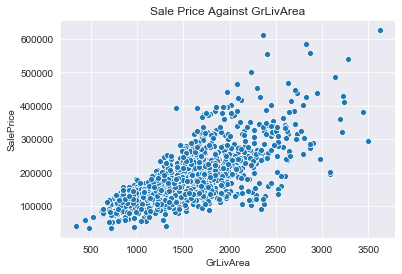

In [40]:
# Sale price against GrLivArea

sns.set_style('darkgrid')
sns.scatterplot(x = 'GrLivArea', y = 'SalePrice', data = train)
plt.title('Sale Price Against GrLivArea')

Text(0.5, 1.0, 'Sale Price Against TotalBsmtSF')

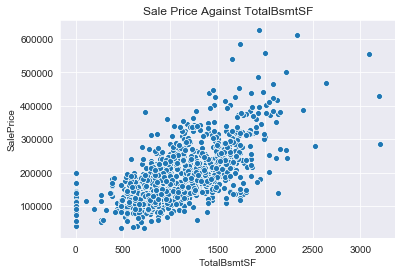

In [41]:
# Sale price against TotalBsmtSF

sns.set_style('darkgrid')
sns.scatterplot(x = 'TotalBsmtSF', y = 'SalePrice', data = train)
plt.title('Sale Price Against TotalBsmtSF')

# Data preprocessing

## Apply log transformation to target variable

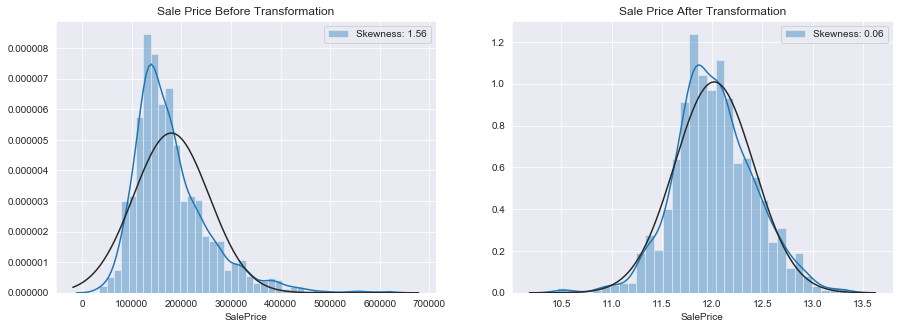

In [42]:
# Create axes to draw plots
fig, ax = plt.subplots(1, 2)

# Plot original SalePrice distribution
sns.distplot(train['SalePrice'], fit = norm, label = 'Skewness: %.2f'%train['SalePrice'].skew(), ax = ax[0])
ax[0].legend(loc = 'best')
ax[0].title.set_text('Sale Price Before Transformation')

# Apply box-cox transformation
train['SalePrice'] = np.log1p(train['SalePrice'])

# Plot transformed SalePrice distribution
sns.distplot(train['SalePrice'], fit = norm, label = 'Skewness: %.2f'%train['SalePrice'].skew(), ax = ax[1])
ax[1].legend(loc = 'best')
ax[1].title.set_text('Sale Price After Transformation')

# Rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(15)

## Apply Box-Cox transformation to numerical features with high skewness 

In [43]:
# Combine training and test set 

combine = pd.concat([train, test])

In [44]:
print("Training set shape: ", train.shape)
print("Test set shape: ", test.shape)
print("Combined shape: ", combine.shape)

Training set shape:  (1450, 63)
Test set shape:  (1459, 62)
Combined shape:  (2909, 63)


In [45]:
skew_features = combine[numerical_features].apply(lambda x: x.skew()).sort_values(ascending = False)
high_skew = skew_features[skew_features > 0.5]
print(f"There are {len(high_skew)} numerical features with skew greater than 0.5. ")
high_skew

There are 24 numerical features with skew greater than 0.5. 


MiscVal          23.519183
PoolArea         21.193156
LotArea          13.176207
LowQualFinSF     13.036103
3SsnPorch        11.361987
KitchenAbvGr      4.351611
BsmtFinSF2        4.155369
BsmtHalfBath      3.969469
EnclosedPorch     3.959649
ScreenPorch       3.901342
OpenPorchSF       2.536797
WoodDeckSF        1.847509
MSSubClass        1.377019
1stFlrSF          1.257344
BsmtFinSF1        0.975649
GrLivArea         0.952542
BsmtUnfSF         0.922864
2ndFlrSF          0.842638
Fireplaces        0.727200
TotRmsAbvGrd      0.695198
HalfBath          0.690867
TotalBsmtSF       0.670999
BsmtFullBath      0.624360
OverallCond       0.564662
dtype: float64

In [46]:
# Normalise skewed features

for feature in high_skew.index:
    combine[feature] = boxcox1p(combine[feature], boxcox_normmax(combine[feature] + 1))

## Encode categorical features

In [47]:
print("Combined shape before: ", combine.shape)
combine = pd.get_dummies(combine)
print("Combined shape after: ", combine.shape)

Combined shape before:  (2909, 63)
Combined shape after:  (2909, 220)


## Get the new training and test set

In [48]:
train = combine[:len(train)]
test = combine[len(train):]

# Modelling

## Single regressor

In [49]:
X_train = train.drop(['Id', 'SalePrice'], axis = 1)
Y_train = train['SalePrice']
X_test = test.drop(['Id', 'SalePrice'], axis = 1)
test_id = test['Id']

In [50]:
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (1450, 218)
Y_train shape:  (1450,)
X_test shape:  (1459, 218)


In [51]:
# Cross validation

kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

In [52]:
# Evaluation metrics

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X = X_train, y = Y_train):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = 'neg_mean_squared_error', cv = kfolds))
    return rmse

In [53]:
# Instantiate regressors

ridge = make_pipeline(RobustScaler(), RidgeCV())
lasso = make_pipeline(RobustScaler(), LassoCV())
elasticnet = ElasticNetCV()
rf = RandomForestRegressor()
svr = SVR()
gbr = GradientBoostingRegressor()
lightgbm = LGBMRegressor()
xgboost = XGBRegressor()

In [54]:
models = [ridge, lasso, elasticnet, rf, svr, gbr, lightgbm, xgboost]
mean = []
std = []
for model in models:
    mean.append(cv_rmse(model).mean())
    std.append(cv_rmse(model).std())

models_df = pd.DataFrame({'Model': ['Ridge', 'Lasso', 'Elastic Net', 'Random Forest', 'SVR', 'Gradient Boosting', 'Light GBM', 'XGBoost'],
                         'Mean': mean, 'Std': std})
models_df.sort_values(by = 'Mean', inplace = True, ignore_index = True)

[13:00:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:00:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:00:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:00:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:00:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:00:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:00:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:00:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:00:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [55]:
models_df

,Model,Mean,Std
0,Lasso,0.107209,0.016094
1,Ridge,0.108143,0.015654
2,Gradient Boosting,0.122860,0.013625
3,XGBoost,0.123182,0.015095
4,Light GBM,0.125548,0.015179
5,Random Forest,0.137489,0.014028
6,Elastic Net,0.176303,0.019719
7,SVR,0.192353,0.020835


In [56]:
ridge_model = ridge.fit(X_train, Y_train)
Y_pred = ridge_model.predict(X_test)
len(Y_pred)

1459

In [57]:
len(ss)

1459

In [58]:
ss.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [59]:
ridge_submission = pd.DataFrame({'Id': test_id, 'SalePrice': np.expm1(Y_pred)})
ridge_submission.head()

,Id,SalePrice
0,1461,119177.098512
1,1462,158883.579219
2,1463,185274.937745
3,1464,200511.593093
4,1465,199539.046814


In [60]:
# Save ridge submission

ridge_submission.to_csv("C:/Users/Jason Chong/Documents/Kaggle/house-prices/ridge_submission.csv", index = False)

## Stacked regressions

In [61]:
# Stack models

stack_gen = StackingCVRegressor(regressors = (ridge, lasso, elasticnet, rf, gbr, xgboost, lightgbm), meta_regressor = xgboost, use_features_in_secondary = True)
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(Y_train))

[13:02:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:02:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:02:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:02:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:02:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:02:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:02:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [62]:
ridge_model_full_data = ridge.fit(X_train, Y_train)

In [63]:
lasso_model_full_data = lasso.fit(X_train, Y_train)

In [64]:
elastic_model_full_data = elasticnet.fit(X_train, Y_train)

In [65]:
rf_model_full_data = rf.fit(X_train, Y_train)

In [66]:
svr_model_full_data = svr.fit(X_train, Y_train)

In [67]:
gbr_model_full_data = gbr.fit(X_train, Y_train)

In [68]:
lgb_model_full_data = lightgbm.fit(X_train, Y_train)

In [69]:
xgb_model_full_data = xgboost.fit(X_train, Y_train)

[13:03:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [70]:
# Blend models and get predictions

def blended_predictions(X):
    return ((0.05 * ridge_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.05 * elastic_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.05 * svr_model_full_data.predict(X)) + \
            (0.05 * gbr_model_full_data.predict(X)) + \
            (0.05 * lgb_model_full_data.predict(X)) + \
            (0.05 * xgb_model_full_data.predict(X)) + \
            (0.6 * stack_gen_model.predict(np.array(X))))

In [71]:
# Get final predictions from the blended model

blended_score = rmse(Y_train, blended_predictions(X_train))
print("RMSE score on training data: ", blended_score)

RMSE score on training data:  0.07596542733053291


In [72]:
Y_pred = blended_predictions(X_test)
Y_pred

array([11.73385443, 11.95357495, 12.11940934, ..., 12.01826126,
       11.66168695, 12.36319502])

In [73]:
blended_submission = pd.DataFrame({'Id': test_id, 'SalePrice': np.expm1(Y_pred)})
blended_submission.head()

,Id,SalePrice
0,1461,124722.482966
1,1462,155370.600762
2,1463,183396.157825
3,1464,197566.649558
4,1465,191320.445428


In [74]:
# Save blended submission

blended_submission.to_csv("C:/Users/Jason Chong/Documents/Kaggle/house-prices/blended_submission.csv", index = False)